# Evaluation Pipeline Testing Notebook
## Reasoning Distillation Project

This notebook performs **final evaluation on the TEST SET** for:

1. Individual metrics (Accuracy, ROUGE, BERTScore, Faithfulness)
2. Full evaluation pipeline on Test Set
3. Error analysis and confusion matrix
4. Per-label evaluation
5. Model comparison
6. Batch evaluation
7. Results visualization


In [1]:
# Setup
import sys
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import pandas as pd

from src.data.data_loader import TeacherDataLoader
from src.data.preprocessor import ReasoningPreprocessor, PreprocessConfig
from src.data.dataset import ESNLIDataset, create_dataloaders

from src.models.student import StudentModel, StudentConfig

from src.evaluation.metrics import (
    LabelAccuracyMetric,
    ROUGEMetric,
    BERTScoreMetric,
    ExplanationFaithfulnessMetric,
    StudentTeacherAgreementMetric,
    compute_all_metrics,
    MetricsConfig,
    format_metrics
)

from src.evaluation.evaluator import (
    EvaluationConfig,
    Evaluator,
    BatchEvaluator,
    quick_evaluate
)

In [2]:
# Set device (GPU or CPU)
# This determines where models and tensors will be loaded during training
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Test Individual Metrics

In [3]:
# Create sample predictions and references
print("=" * 70)
print("TESTING INDIVIDUAL METRICS")
print("=" * 70)

sample_predictions = [
    "entailment explanation: The person is definitely on a horse.",
    "neutral explanation: We cannot determine if they are training.",
    "contradiction explanation: The person cannot be both inside and outside.",
    "entailment explanation: This clearly follows from the premise.",
    "neutral explanation: It's unclear what the intention is."
]

sample_references = [
    "entailment explanation: The premise states a person is on a horse.",
    "neutral explanation: Training is not mentioned in the premise.",
    "contradiction explanation: These are mutually exclusive locations.",
    "entailment explanation: The hypothesis is supported by the premise.",
    "contradiction explanation: The actions contradict each other."  # Mismatch for testing
]

print(f"\nCreated {len(sample_predictions)} test samples")

TESTING INDIVIDUAL METRICS

Created 5 test samples


### 1.1 Test Label Accuracy

In [4]:
# Test label accuracy metric
print("\n" + "=" * 70)
print("LABEL ACCURACY METRIC")
print("=" * 70)

label_metric = LabelAccuracyMetric()

# Test label extraction
print("\nLabel extraction test:")
for pred in sample_predictions[:3]:
    label = label_metric.extract_label(pred)
    print(f"  '{pred[:40]}...' → {label}")

# Compute accuracy
accuracy_results = label_metric.compute(sample_predictions, sample_references)

print("\nAccuracy results:")
print(format_metrics(accuracy_results))


LABEL ACCURACY METRIC

Label extraction test:
  'entailment explanation: The person is de...' → entailment
  'neutral explanation: We cannot determine...' → neutral
  'contradiction explanation: The person ca...' → contradiction

Accuracy results:
  accuracy_contradiction: 0.5000
  accuracy_entailment: 1.0000
  accuracy_neutral: 1.0000
  label_accuracy: 0.8000
  valid_predictions: 5


### 1.2 Test ROUGE Scores

In [5]:
# Test ROUGE metric
print("\n" + "=" * 70)
print("ROUGE METRIC")
print("=" * 70)

rouge_metric = ROUGEMetric()

if rouge_metric.available:
    # Test explanation extraction
    print("\nExplanation extraction test:")
    for pred in sample_predictions[:2]:
        explanation = rouge_metric.extract_explanation(pred)
        print(f"  Input: {pred}")
        print(f"  Extracted: {explanation}\n")
    
    # Compute ROUGE
    rouge_results = rouge_metric.compute(sample_predictions, sample_references)
    
    print("ROUGE results:")
    print(format_metrics(rouge_results))
else:
    print("\nROUGE not available. Install with: pip install rouge-score")

INFO:absl:Using default tokenizer.



ROUGE METRIC

Explanation extraction test:
  Input: entailment explanation: The person is definitely on a horse.
  Extracted: the person is definitely on a horse.

  Input: neutral explanation: We cannot determine if they are training.
  Extracted: we cannot determine if they are training.

ROUGE results:
  rouge1: 0.2734
  rouge2: 0.1221
  rougeL: 0.2734


### 1.3 Test BERTScore

In [6]:
# Test BERTScore metric
print("\n" + "=" * 70)
print("BERTSCORE METRIC")
print("=" * 70)

bertscore_metric = BERTScoreMetric()

if bertscore_metric.available:
    print("\nComputing BERTScore (this may take a moment)...")
    bertscore_results = bertscore_metric.compute(
        sample_predictions, 
        sample_references,
        batch_size=8
    )
    
    print("\nBERTScore results:")
    print(format_metrics(bertscore_results))
else:
    print("\nBERTScore not available. Install with: pip install bert-score")


BERTSCORE METRIC

Computing BERTScore (this may take a moment)...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]


BERTScore results:
  bertscore_f1: 0.6798
  bertscore_precision: 0.6811
  bertscore_recall: 0.6792


### 1.4 Test Explanation Faithfulness

In [7]:
# Test faithfulness metric
print("\n" + "=" * 70)
print("EXPLANATION FAITHFULNESS METRIC")
print("=" * 70)

faithfulness_metric = ExplanationFaithfulnessMetric()

# Test individual faithfulness checks
print("\nFaithfulness checks:")
for pred in sample_predictions:
    label, explanation = faithfulness_metric.extract_label_and_explanation(pred)
    if label is not None:
        is_faithful = faithfulness_metric.check_faithfulness(label, explanation)
        status = "✓" if is_faithful else "✗"
        print(f"  {status} {label}: {explanation[:50]}...")
    else:
        print(f"  ✗ No label found: {explanation[:50]}...")

# Compute overall faithfulness
faithfulness_results = faithfulness_metric.compute(sample_predictions)

print("\nFaithfulness results:")
print(format_metrics(faithfulness_results))


EXPLANATION FAITHFULNESS METRIC

Faithfulness checks:
  ✓ entailment: the person is definitely on a horse....
  ✓ neutral: we cannot determine if they are training....
  ✓ contradiction: the person cannot be both inside and outside....
  ✓ entailment: this clearly follows from the premise....
  ✓ neutral: it's unclear what the intention is....

Faithfulness results:
  faithfulness: 1.0000
  valid_predictions: 5


### 1.5 Test All Metrics Combined

In [8]:
# Compute all metrics at once
print("\n" + "=" * 70)
print("ALL METRICS COMBINED")
print("=" * 70)

metrics_config = MetricsConfig(
    compute_rouge=True,
    compute_bertscore=True,
    compute_faithfulness=True
)

all_metrics = compute_all_metrics(
    sample_predictions,
    sample_references,
    metrics_config
)

print("\nAll metrics:")
print(format_metrics(all_metrics))

INFO:absl:Using default tokenizer.



ALL METRICS COMBINED

All metrics:
  accuracy_contradiction: 0.5000
  accuracy_entailment: 1.0000
  accuracy_neutral: 1.0000
  bertscore_f1: 0.6798
  bertscore_precision: 0.6811
  bertscore_recall: 0.6792
  faithfulness: 1.0000
  label_accuracy: 0.8000
  rouge1: 0.2734
  rouge2: 0.1221
  rougeL: 0.2734
  valid_predictions: 5


## 2. Prepare Test Data and Model

In [ ]:
# Load test data
print("=" * 70)
print("LOADING TEST DATA")
print("=" * 70)

loader = TeacherDataLoader()
esnli_data = loader.load_esnli()

# Use TEST SET for final evaluation
test_subset = esnli_data['test'].select(range(1000))  # Full test set for proper evaluation


print(f"\n✓ Test samples: {len(test_subset)}")

INFO:src.data.data_loader:Loading e-SNLI dataset from GitHub (OanaMariaCamburu/e-SNLI)...


LOADING TEST DATA


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/259999 [00:00<?, ? examples/s]

Map:   0%|          | 0/289368 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

INFO:src.data.data_loader:✓ Loaded e-SNLI: train=549367, val=9842, test=9824
INFO:src.data.data_loader:e-SNLI loaded successfully. Splits: ['train', 'validation', 'test']
INFO:src.data.data_loader:Sample counts: [('train', 549367), ('validation', 9842), ('test', 9824)]



✓ Test samples: 50


In [10]:
# Create dataset and dataloader
preprocess_config = PreprocessConfig(
    model_name="google/flan-t5-small",
    max_source_length=128,
    max_target_length=64
)

preprocessor = ReasoningPreprocessor(preprocess_config)
test_dataset = ESNLIDataset(test_subset, preprocessor, use_cache=True)

test_loader = create_dataloaders(
    test_dataset,
    batch_size=8,
    num_workers=0,
    pad_token_id=preprocessor.tokenizer.pad_token_id,
    shuffle_train=False
)

print(f"✓ Test batches: {len(test_loader)}")

INFO:src.data.preprocessor:Loading tokenizer: google/flan-t5-small


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

INFO:src.data.dataset:Initialized ESNLIDataset with 50 samples


✓ Test batches: 7


In [11]:
# Load model from checkpoint
print("\n" + "=" * 70)
print("LOADING MODEL FROM CHECKPOINT")
print("=" * 70)

import zipfile

# Path to checkpoint
checkpoint_dir = Path("../experiments/distillation")
model_zip = checkpoint_dir / "best_model.zip"
model_dir = checkpoint_dir / "best_model"

# Extract if needed
if model_zip.exists() and not model_dir.exists():
    print(f"Extracting model from {model_zip}...")
    with zipfile.ZipFile(model_zip, 'r') as zip_ref:
        zip_ref.extractall(checkpoint_dir)
    print("✓ Extracted successfully")

# Load model from checkpoint
if model_dir.exists():
    student_config = StudentConfig(
        max_source_length=128,
        max_target_length=64,
        device=device,
        num_beams=4
    )
    
    student = StudentModel.load_model(str(model_dir), student_config)
    print(f"\n✓ Model loaded from: {model_dir}")
    print(f"✓ Parameters: {student.count_parameters():,}")
else:
    print(f"ERROR: Model directory not found: {model_dir}")
    print(f"  Make sure best_model.zip is in {checkpoint_dir}")


LOADING MODEL FROM CHECKPOINT
Extracting model from ../experiments/distillation/best_model.zip...


INFO:src.models.student:Loading model from ../experiments/distillation/best_model
INFO:src.models.student:Initializing student model: ../experiments/distillation/best_model
The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152


✓ Extracted successfully

✓ Model loaded from: ../experiments/distillation/best_model
✓ Parameters: 76,961,152


## 3. Test Full Evaluation Pipeline

In [12]:
# Create evaluator
print("=" * 70)
print("INITIALIZING EVALUATOR")
print("=" * 70)

eval_config = EvaluationConfig(
    metrics_config=MetricsConfig(
        compute_rouge=True,
        compute_bertscore=False,  # Skip BERTScore for speed
        compute_faithfulness=True
    ),
    num_beams=4,
    max_length=64,
    save_predictions=True,
    save_detailed_results=True,
    analyze_errors=True,
    num_error_examples=5,
    output_dir="../experiments/evaluation_test"
)

evaluator = Evaluator(student, eval_config)

print("\n✓ Evaluator initialized!")

INFO:src.evaluation.evaluator:Evaluator initialized with output dir: ../experiments/evaluation_test


INITIALIZING EVALUATOR

✓ Evaluator initialized!


In [13]:
# Run evaluation
print("\n" + "=" * 70)
print("RUNNING FULL EVALUATION")
print("=" * 70)

results = evaluator.evaluate(test_loader, split_name="test")

print("\n✓ Evaluation complete!")

INFO:src.evaluation.evaluator:Starting evaluation on test split...
INFO:src.evaluation.evaluator:Total batches: 7



RUNNING FULL EVALUATION


Evaluating test: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]
INFO:src.evaluation.evaluator:Generation complete in 4.30s
INFO:src.evaluation.evaluator:Generated 50 predictions
INFO:src.evaluation.evaluator:Computing metrics...
INFO:absl:Using default tokenizer.
INFO:src.evaluation.evaluator:Analyzing errors...
INFO:src.evaluation.evaluator:Saved metrics to ../experiments/evaluation_test/test_metrics.json
INFO:src.evaluation.evaluator:Saved predictions to ../experiments/evaluation_test/test_predictions.jsonl
INFO:src.evaluation.evaluator:Saved error analysis to ../experiments/evaluation_test/test_analysis.json
INFO:src.evaluation.evaluator:
INFO:src.evaluation.evaluator:Evaluation Results - test
INFO:src.evaluation.evaluator:======================================================================
INFO:src.evaluation.evaluator:  accuracy_contradiction: 0.9000
  accuracy_entailment: 1.0000
  accuracy_neutral: 0.7500
  eval_time_seconds: 4.2988
  faithfulness: 0.6600
  label_accuracy: 0.880


✓ Evaluation complete!


In [14]:
# Display results
print("\n" + "=" * 70)
print("EVALUATION RESULTS")
print("=" * 70)

metrics = results['metrics']
print("\nMetrics:")
print(format_metrics(metrics))

print(f"\nGenerated {len(results['predictions'])} predictions")
print(f"Evaluation time: {metrics['eval_time_seconds']:.2f}s")
print(f"Throughput: {metrics['samples_per_second']:.2f} samples/sec")


EVALUATION RESULTS

Metrics:
  accuracy_contradiction: 0.9000
  accuracy_entailment: 1.0000
  accuracy_neutral: 0.7500
  eval_time_seconds: 4.2988
  faithfulness: 0.6600
  label_accuracy: 0.8800
  loss: 1.0269
  rouge1: 0.4636
  rouge2: 0.2523
  rougeL: 0.4116
  samples_per_second: 11.6312
  valid_predictions: 50

Generated 50 predictions
Evaluation time: 4.30s
Throughput: 11.63 samples/sec


## 4. Analyze Predictions

In [15]:
# Display sample predictions
print("=" * 70)
print("SAMPLE PREDICTIONS")
print("=" * 70)

predictions = results['predictions']
references = results['references']
inputs = results['inputs']

for i in range(min(3, len(predictions))):
    print(f"\n{'='*70}")
    print(f"SAMPLE {i+1}")
    print(f"{'='*70}")
    print(f"\nInput:\n{inputs[i]}")
    print(f"\nReference:\n{references[i]}")
    print(f"\nPrediction:\n{predictions[i]}")

SAMPLE PREDICTIONS

SAMPLE 1

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: The sisters are hugging goodbye while holding to go packages after just eating lunch.

Reference:
neutral explanation: The to go packages may not be from lunch.

Prediction:
neutral explanation: Just because two women are embracing does not mean they are sisters.

SAMPLE 2

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: Two woman are holding packages.

Reference:
entailment explanation: Saying the two women are holding packages is a way to paraphrase that the packages they are holding are to go packages.

Prediction:
entailment explanation: Holding packages is a rephrasing of holding packages.

SAMPLE 3

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: The men are fighting outside a deli.

Reference:
contradiction explanation: In the first sentence there is an action of affection between women whi

## 5. Error Analysis

In [16]:
# Display error analysis
print("=" * 70)
print("ERROR ANALYSIS")
print("=" * 70)

error_analysis = results['error_analysis']

if error_analysis:
    print(f"\nTotal errors: {error_analysis['total_errors']}")
    print(f"Error rate: {error_analysis['error_rate']:.2%}")
    
    # Display confusion matrix
    print("\n" + "=" * 70)
    print("CONFUSION MATRIX")
    print("=" * 70)
    
    confusion = error_analysis['confusion_matrix']
    
    # Create DataFrame for better display
    labels = ['entailment', 'neutral', 'contradiction']
    confusion_df = pd.DataFrame(
        [[confusion[true_label][pred_label] for pred_label in labels]
         for true_label in labels],
        index=labels,
        columns=labels
    )
    
    print("\n", confusion_df)
    
    # Sample errors
    print("\n" + "=" * 70)
    print("SAMPLE ERRORS")
    print("=" * 70)
    
    for i, error in enumerate(error_analysis['sample_errors'][:3], 1):
        print(f"\n--- Error {i} ---")
        print(f"Predicted: {error['predicted_label']}")
        print(f"True: {error['true_label']}")
        print(f"Input: {error['input'][:100]}...")
        print(f"Prediction: {error['prediction'][:100]}...")
else:
    print("\nNo error analysis available")

ERROR ANALYSIS

Total errors: 6
Error rate: 12.00%

CONFUSION MATRIX

                entailment  neutral  contradiction
entailment             14        0              0
neutral                 1       12              3
contradiction           1        1             18

SAMPLE ERRORS

--- Error 1 ---
Predicted: neutral
True: contradiction
Input: nli premise: A woman is doing a cartwheel while wearing a bikini in the sand next to the beach. hypo...
Prediction: neutral explanation: Just because a woman is doing a cartwheel does not mean she falls on her head....

--- Error 2 ---
Predicted: contradiction
True: neutral
Input: nli premise: Two men on bicycles competing in a race. hypothesis: Men are riding bicycles on the str...
Prediction: contradiction explanation: The men cannot be riding bicycles on the street and competing in a race a...

--- Error 3 ---
Predicted: contradiction
True: neutral
Input: nli premise: A young boy in a field of flowers carrying a ball hypothesis: boy leaving

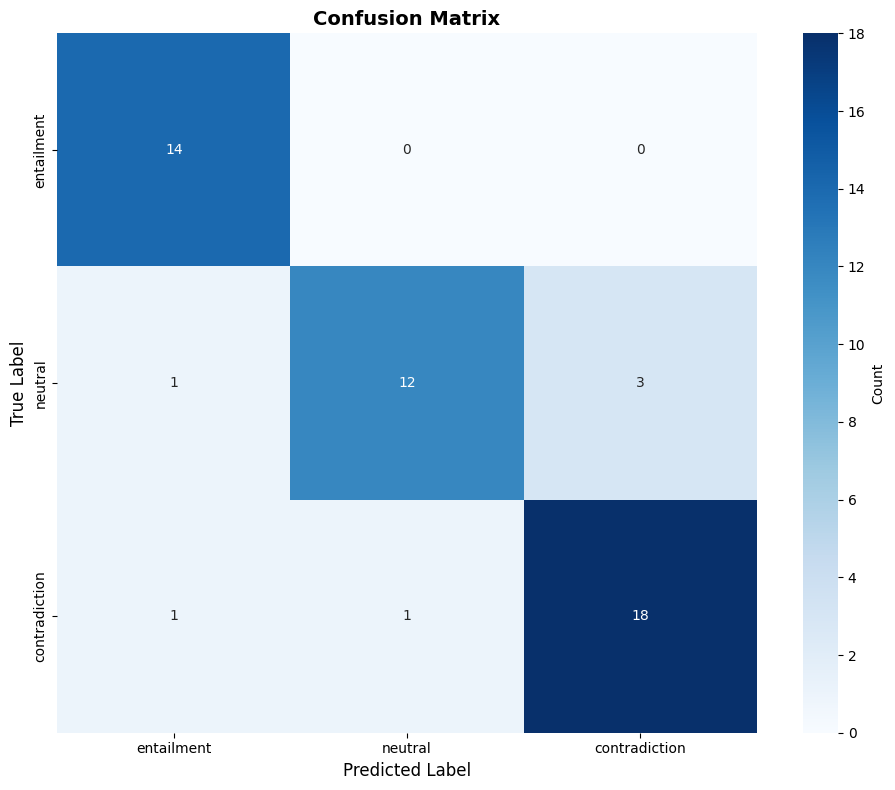

In [17]:
# Visualize confusion matrix
if error_analysis:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(
        confusion_df,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar_kws={'label': 'Count'},
        ax=ax
    )
    
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 6. Per-Label Evaluation

In [18]:
# Evaluate performance by label
print("=" * 70)
print("PER-LABEL EVALUATION")
print("=" * 70)

per_label_metrics = evaluator.evaluate_by_label(test_loader)

print("\n✓ Per-label evaluation complete!")

INFO:src.evaluation.evaluator:Evaluating by label...
INFO:src.evaluation.evaluator:Starting evaluation on by_label split...
INFO:src.evaluation.evaluator:Total batches: 7


PER-LABEL EVALUATION


Evaluating by_label: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]
INFO:src.evaluation.evaluator:Generation complete in 4.10s
INFO:src.evaluation.evaluator:Generated 50 predictions
INFO:src.evaluation.evaluator:Computing metrics...
INFO:absl:Using default tokenizer.
INFO:src.evaluation.evaluator:Analyzing errors...
INFO:src.evaluation.evaluator:Saved metrics to ../experiments/evaluation_test/by_label_metrics.json
INFO:src.evaluation.evaluator:Saved predictions to ../experiments/evaluation_test/by_label_predictions.jsonl
INFO:src.evaluation.evaluator:Saved error analysis to ../experiments/evaluation_test/by_label_analysis.json
INFO:src.evaluation.evaluator:
INFO:src.evaluation.evaluator:Evaluation Results - by_label
INFO:src.evaluation.evaluator:======================================================================
INFO:src.evaluation.evaluator:  accuracy_contradiction: 0.9000
  accuracy_entailment: 1.0000
  accuracy_neutral: 0.7500
  eval_time_seconds: 4.1038
  faithfulness: 0.6600
  l


✓ Per-label evaluation complete!


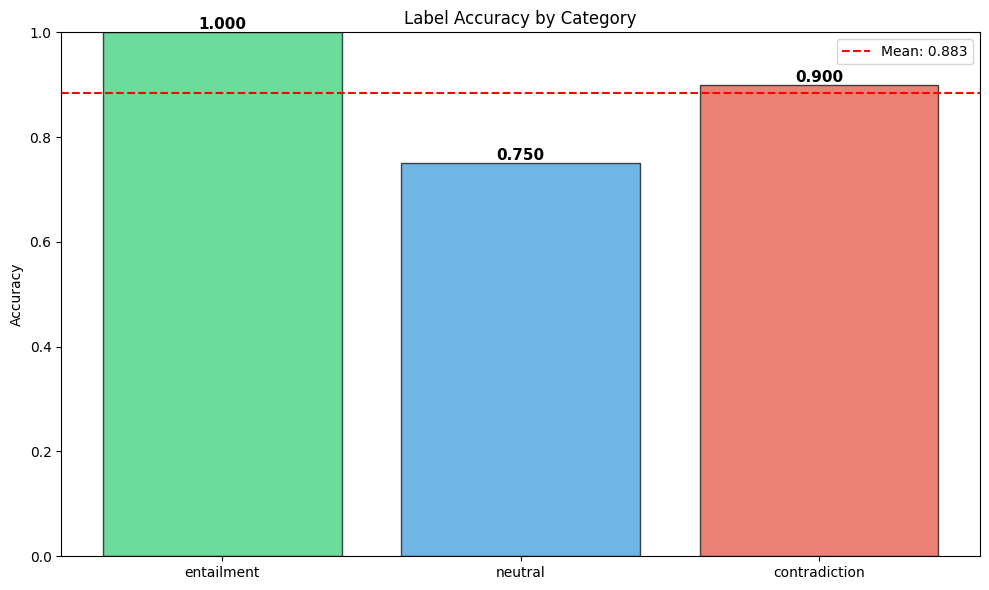

In [19]:
# Visualize per-label accuracy
if per_label_metrics:
    labels = list(per_label_metrics.keys())
    accuracies = [per_label_metrics[label].get('label_accuracy', 0) 
                  for label in labels]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    bars = ax.bar(labels, accuracies, color=colors, alpha=0.7, edgecolor='black')
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Label Accuracy by Category')
    ax.set_ylim(0, 1.0)
    ax.axhline(y=float(np.mean(accuracies)), color='red', linestyle='--', 
               label=f'Mean: {np.mean(accuracies):.3f}')
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.legend()
    plt.tight_layout()
    plt.show()

## 7. Compare Metrics Across Labels

METRICS COMPARISON ACROSS LABELS

         label  label_accuracy   rouge1   rouge2   rougeL  faithfulness
   entailment            1.00 0.582099 0.382349 0.548990          1.00
      neutral            0.75 0.436466 0.226499 0.383813          0.25
contradiction            0.90 0.402422 0.181790 0.337675          0.75


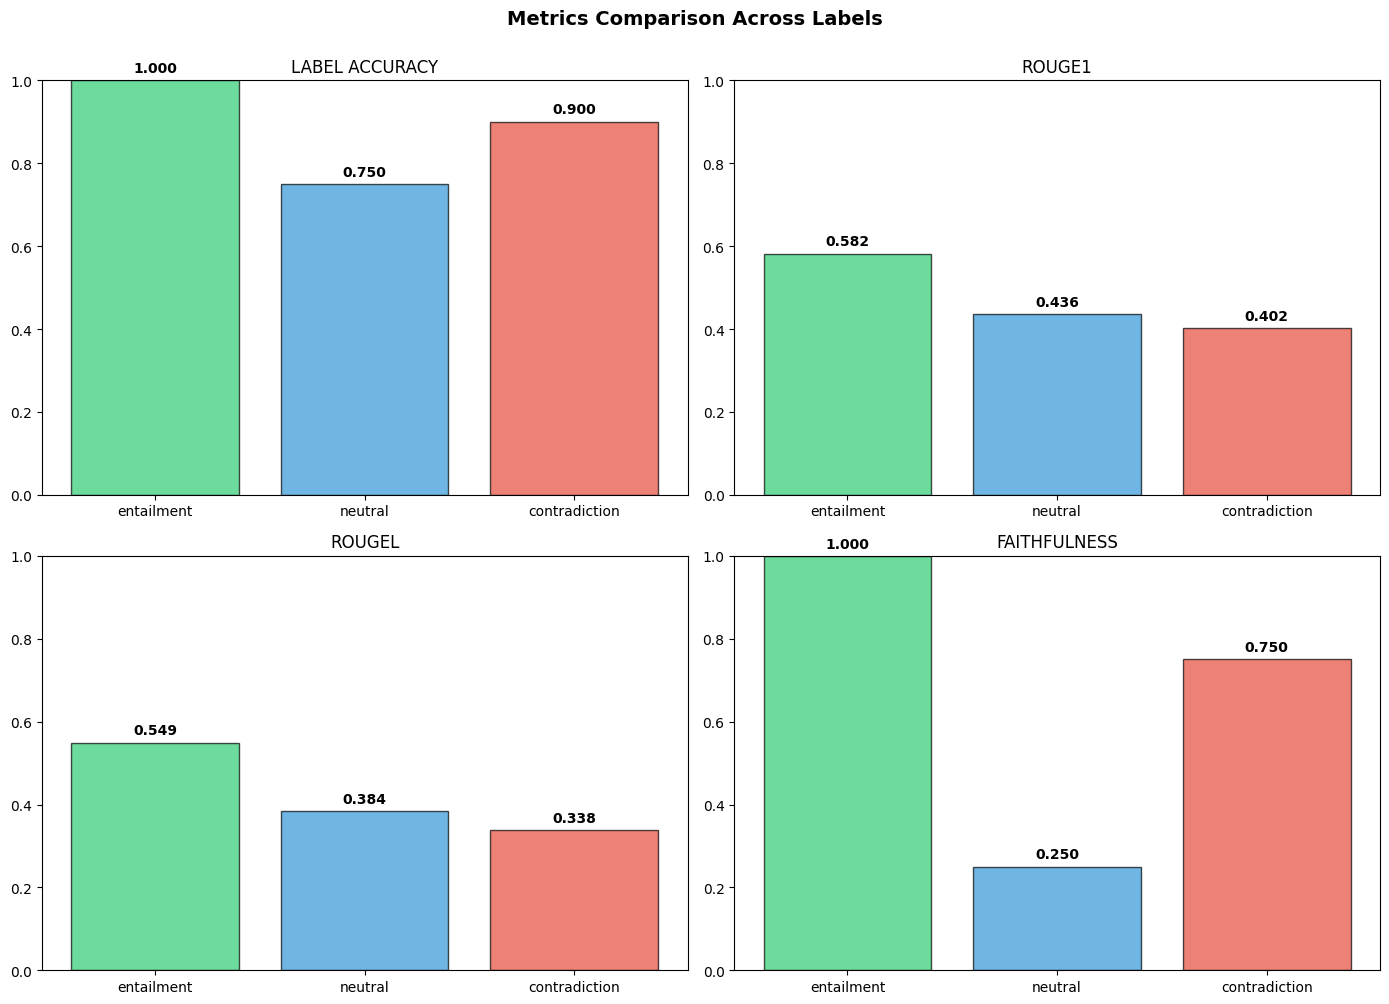

In [20]:
# Create comparison DataFrame
if per_label_metrics:
    print("=" * 70)
    print("METRICS COMPARISON ACROSS LABELS")
    print("=" * 70)
    
    # Extract common metrics
    metric_names = ['label_accuracy', 'rouge1', 'rouge2', 'rougeL', 'faithfulness']
    
    comparison_data = []
    for label in labels:
        row: dict = {'label': label}
        for metric in metric_names:
            row[metric] = float(per_label_metrics[label].get(metric, 0))
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n", comparison_df.to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    metrics_to_plot = ['label_accuracy', 'rouge1', 'rougeL', 'faithfulness']
    
    for idx, metric in enumerate(metrics_to_plot):
        values = comparison_df[metric].values
        axes[idx].bar(labels, values, color=colors, alpha=0.7, edgecolor='black')
        axes[idx].set_title(metric.upper().replace('_', ' '))
        axes[idx].set_ylim(0, 1.0)
        
        # Add values
        for i, v in enumerate(values):
            axes[idx].text(i, v + 0.02, f'{v:.3f}', 
                          ha='center', fontsize=10, fontweight='bold')
    
    plt.suptitle('Metrics Comparison Across Labels', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

## 9. Test Batch Evaluator (Multiple Models)

In [22]:
# Create batch evaluator
print("=" * 70)
print("TESTING BATCH EVALUATOR")
print("=" * 70)

batch_evaluator = BatchEvaluator(
    output_dir="../experiments/batch_evaluation_test"
)

# Add current model evaluation (flan-t5-small)
print("\nEvaluating Model 1 (FLAN-T5-small)...")
batch_evaluator.add_evaluation(
    "flan-t5-small",
    evaluator,
    test_loader
)

# Create and evaluate flan-t5-base model
print("\nEvaluating Model 2 (FLAN-T5-base)...")

# Initialize base model
student_config_base = StudentConfig(
    model_name="google/flan-t5-base",
    max_source_length=128,
    max_target_length=64,
    device=device,
    num_beams=4
)

student_base = StudentModel(student_config_base)

# Create evaluator for base model
eval_config_base = EvaluationConfig(
    metrics_config=MetricsConfig(
        compute_rouge=True,
        compute_bertscore=False,  # Skip BERTScore for speed
        compute_faithfulness=True
    ),
    num_beams=4,
    max_length=64,
    save_predictions=True,
    save_detailed_results=True,
    analyze_errors=True,
    num_error_examples=5,
    output_dir="../experiments/evaluation_base_test"
)

evaluator_base = Evaluator(student_base, eval_config_base)

# Add base model evaluation
batch_evaluator.add_evaluation(
    "flan-t5-base",
    evaluator_base,
    test_loader
)

# Display batch results
print("\n" + "=" * 70)
print("BATCH EVALUATION RESULTS")
print("=" * 70)

for result in batch_evaluator.results:
    print(f"\nModel: {result['model_name']}")
    print(format_metrics(result['metrics']))


INFO:src.evaluation.evaluator:Evaluating flan-t5-small...
INFO:src.evaluation.evaluator:Starting evaluation on flan-t5-small split...
INFO:src.evaluation.evaluator:Total batches: 7


TESTING BATCH EVALUATOR

Evaluating Model 1 (FLAN-T5-small)...


Evaluating flan-t5-small: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]
INFO:src.evaluation.evaluator:Generation complete in 4.11s
INFO:src.evaluation.evaluator:Generated 50 predictions
INFO:src.evaluation.evaluator:Computing metrics...
INFO:absl:Using default tokenizer.
INFO:src.evaluation.evaluator:Analyzing errors...
INFO:src.evaluation.evaluator:Saved metrics to ../experiments/evaluation_test/flan-t5-small_metrics.json
INFO:src.evaluation.evaluator:Saved predictions to ../experiments/evaluation_test/flan-t5-small_predictions.jsonl
INFO:src.evaluation.evaluator:Saved error analysis to ../experiments/evaluation_test/flan-t5-small_analysis.json
INFO:src.evaluation.evaluator:
INFO:src.evaluation.evaluator:Evaluation Results - flan-t5-small
INFO:src.evaluation.evaluator:======================================================================
INFO:src.evaluation.evaluator:  accuracy_contradiction: 0.9000
  accuracy_entailment: 1.0000
  accuracy_neutral: 0.7500
  eval_time_seconds: 4.1115
 


Evaluating Model 2 (FLAN-T5-base)...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 247,577,856
INFO:src.evaluation.evaluator:Evaluator initialized with output dir: ../experiments/evaluation_base_test
INFO:src.evaluation.evaluator:Evaluating flan-t5-base...
INFO:src.evaluation.evaluator:Starting evaluation on flan-t5-base split...
INFO:src.evaluation.evaluator:Total batches: 7
Evaluating flan-t5-base: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
INFO:src.evaluation.evaluator:Generation complete in 5.45s
INFO:src.evaluation.evaluator:Generated 50 predictions
INFO:src.evaluation.evaluator:Computing metrics...
INFO:absl:Using default tokenizer.
INFO:src.evaluation.evaluator:Analyzing errors...
INFO:src.evaluation.evaluator:Saved metrics to ../experiments/evaluation_base_test/flan-t5-base_metrics.json
INFO:src.evaluation.evaluator:Saved predictions to ../experiments/evaluation_base_test/flan-t5-base_predictions.jsonl
INFO:src.evaluation.evaluator:Saved error analysis to ..


BATCH EVALUATION RESULTS

Model: flan-t5-small
  accuracy_contradiction: 0.9000
  accuracy_entailment: 1.0000
  accuracy_neutral: 0.7500
  eval_time_seconds: 4.1115
  faithfulness: 0.6600
  label_accuracy: 0.8800
  loss: 1.0269
  rouge1: 0.4636
  rouge2: 0.2523
  rougeL: 0.4116
  samples_per_second: 12.1610
  valid_predictions: 50

Model: flan-t5-base
  eval_time_seconds: 5.4456
  faithfulness: 0.0000
  label_accuracy: 0.0000
  loss: 2.7434
  rouge1: 0.0634
  rouge2: 0.0138
  rougeL: 0.0515
  samples_per_second: 9.1818
  valid_predictions: 0



BATCH RESULTS VISUALIZATION


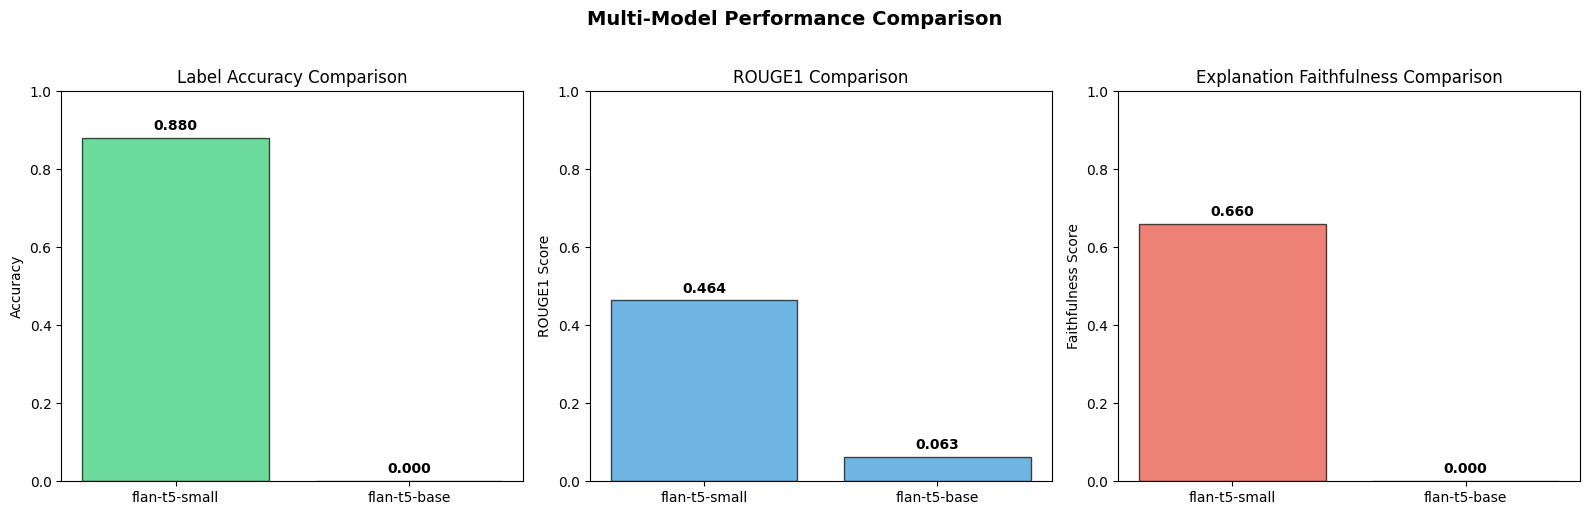

In [23]:
# Visualize batch results comparison
if len(batch_evaluator.results) > 0:
    print("\n" + "=" * 70)
    print("BATCH RESULTS VISUALIZATION")
    print("=" * 70)
    
    # Extract metrics for comparison
    models = [r['model_name'] for r in batch_evaluator.results]
    accuracy_scores = [r['metrics'].get('label_accuracy', 0) for r in batch_evaluator.results]
    rouge1_scores = [r['metrics'].get('rouge1', 0) for r in batch_evaluator.results]
    faithfulness_scores = [r['metrics'].get('faithfulness', 0) for r in batch_evaluator.results]
    
    # Create comparison visualizations
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Plot 1: Accuracy
    axes[0].bar(models, accuracy_scores, color='#2ecc71', alpha=0.7, edgecolor='black')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Label Accuracy Comparison')
    axes[0].set_ylim(0, 1.0)
    for i, v in enumerate(accuracy_scores):
        axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    # Plot 2: ROUGE1
    axes[1].bar(models, rouge1_scores, color='#3498db', alpha=0.7, edgecolor='black')
    axes[1].set_ylabel('ROUGE1 Score')
    axes[1].set_title('ROUGE1 Comparison')
    axes[1].set_ylim(0, 1.0)
    for i, v in enumerate(rouge1_scores):
        axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    # Plot 3: Faithfulness
    axes[2].bar(models, faithfulness_scores, color='#e74c3c', alpha=0.7, edgecolor='black')
    axes[2].set_ylabel('Faithfulness Score')
    axes[2].set_title('Explanation Faithfulness Comparison')
    axes[2].set_ylim(0, 1.0)
    for i, v in enumerate(faithfulness_scores):
        axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    plt.suptitle('Multi-Model Performance Comparison', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


In [24]:
# Save batch evaluation report
print("\n" + "=" * 70)
print("SAVING BATCH EVALUATION REPORT")
print("=" * 70)

# Create summary DataFrame
report_data = []
for result in batch_evaluator.results:
    metrics = result['metrics']
    row = {
        'Model': result['model_name'],
        'Accuracy': metrics.get('label_accuracy', 0),
        'ROUGE1': metrics.get('rouge1', 0),
        'ROUGE2': metrics.get('rouge2', 0),
        'ROUGEL': metrics.get('rougeL', 0),
        'Faithfulness': metrics.get('faithfulness', 0),
        'Eval Time (s)': metrics.get('eval_time_seconds', 0),
        'Throughput (samples/s)': metrics.get('samples_per_second', 0)
    }
    report_data.append(row)

report_df = pd.DataFrame(report_data)

# Save as CSV
output_path = Path("../experiments/batch_evaluation_test")
output_path.mkdir(parents=True, exist_ok=True)

csv_path = output_path / "batch_comparison_report.csv"
report_df.to_csv(csv_path, index=False)

print(f"\n✓ Report saved to: {csv_path}")
print("\n" + report_df.to_string(index=False))



SAVING BATCH EVALUATION REPORT

✓ Report saved to: ../experiments/batch_evaluation_test/batch_comparison_report.csv

        Model  Accuracy   ROUGE1   ROUGE2   ROUGEL  Faithfulness  Eval Time (s)  Throughput (samples/s)
flan-t5-small      0.88 0.463626 0.252253 0.411607          0.66       4.111487               12.161049
 flan-t5-base      0.00 0.063373 0.013836 0.051509          0.00       5.445565                9.181785
